In [1]:
import numpy as np
import XNLdyn
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings('default')

In [11]:

## Set up the problem
PAR = XNLdyn.XNLpars()

PAR.E_j = [850,]

N_local_fluences_to_calculate = 30
N_pulse_energies = 20
Nsteps_r = 100

pulse_energy_J = 1e-12 # J

PAR.I0 =  [XNLdyn.photons_per_J(PAR.E_j[0])*pulse_energy_J,]
PAR.I0

[7342.95185230678]

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.041e-02 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.421e-02 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.898e-02 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.759e-02 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.198e-02 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.807e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.880e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 8.249e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 8.315e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 8.398e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.988e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.045e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.055e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.068e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.091e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.949e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.967e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.053e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.069e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.088e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.097e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.123e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.249e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.272e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.301e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.147e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.150e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.154e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.161e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.164e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.722e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.731e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.736e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.759e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.763e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.464e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.470e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.499e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.505e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.511e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.422e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.436e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.443e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.478e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.485e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.477e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.484e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.521e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.528e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.536e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.425e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.437e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.443e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.473e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.478e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.170e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.174e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.196e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.200e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.205e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.703e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.706e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.720e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.722e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.725e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.992e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.993e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.998e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.999e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 7.001e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.871e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.869e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.859e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.857e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.855e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.482e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.464e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.461e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.456e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.449e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.759e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.749e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.744e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.718e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.713e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.016e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 5.011e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.985e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.980e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.974e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.259e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.249e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.244e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.219e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.214e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XN

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.216e-04 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.374e-04 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.570e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.453e-04 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.565e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/B

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.960e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -1.405e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.957e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -1.412e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.952e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -2.149e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.420e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -2.154e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.416e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -2.178e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/B

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -2.744e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.937e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -2.748e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.934e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -2.752e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/B

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.533e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.215e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.527e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.219e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.525e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.628e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.177e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.631e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.175e+01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.634e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/B

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.980e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 8.907e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.983e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 8.888e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -3.995e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/B

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.524e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.299e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.507e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.304e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 6.476e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.586e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.579e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.575e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.581e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 4.562e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.815e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.110e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.817e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 3.100e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -4.825e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/B

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.034e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.906e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.036e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 1.898e+00 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.043e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/B

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 9.457e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.240e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 9.395e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.242e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 9.282e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.899e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.410e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.690e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.411e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:16: UserWarning: Found values 2.653e-01 over maximum of 1.0.Core holes in proc_ch_decay()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.558e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.559e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.565e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.566e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.567e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  wa

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.698e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.702e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.703e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.704e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.705e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  wa

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.801e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.802e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.804e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.805e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.806e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  wa

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.858e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.859e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.860e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.861e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:13: UserWarning: Found value up to -5.862e-03 under minimum of 0.Valence occupation in proc_res_inter_Ej()
  wa

<IPython.core.display.Javascript object>


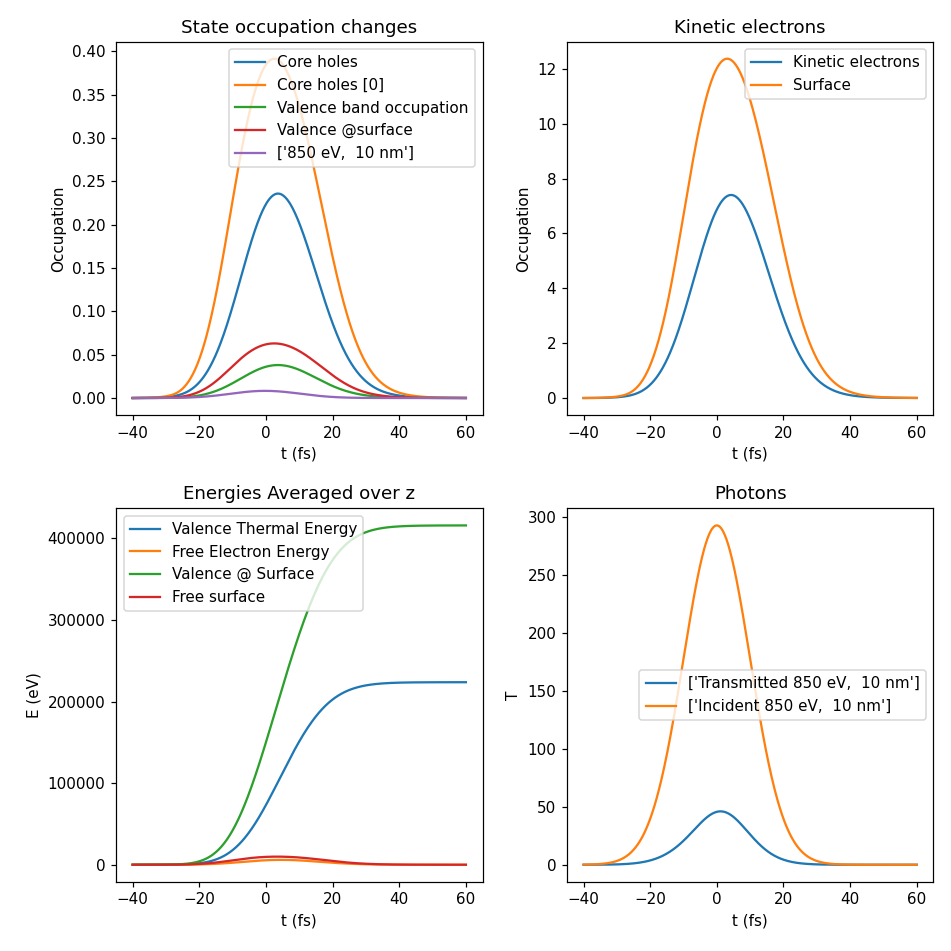

Transmission:  [13.77983588]  %


In [12]:
sim = XNLdyn.XNLsim(PAR, DEBUG = True)

sim_options = dict(t_span=[-40, 60],method='RK45', rtol=1e-6, atol=1e-8, plot = True, return_full_solution = True)

incident, transmitted, sol = sim.run(**sim_options)

print('Transmission: ', 100 * transmitted/incident, ' %')


<IPython.core.display.Javascript object>


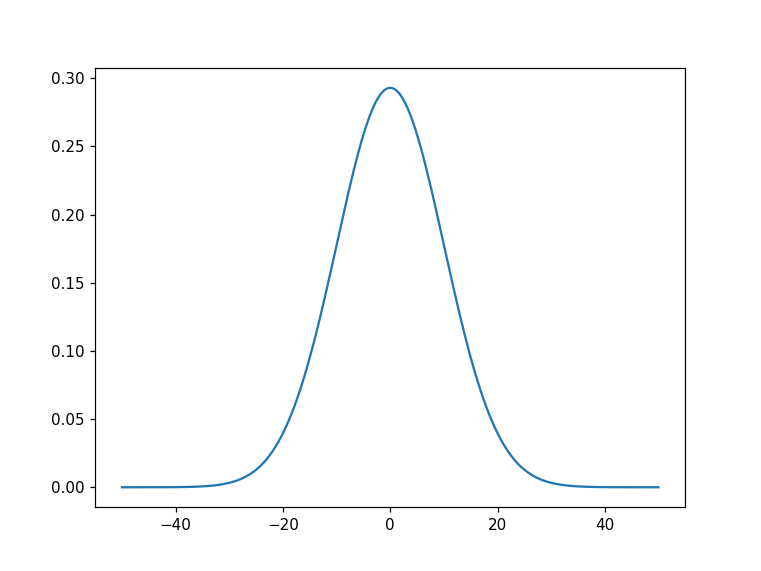

7.342947619617935

In [5]:
t = np.linspace(-50,50,200)
plt.figure()
plt.plot(t,sim.par.pulse_profiles(t))
np.trapz(y= sim.par.pulse_profiles(t),x=t)

In [6]:
a = 1e-8
prec = 1e-8
np.round(a,10)

1e-08

<IPython.core.display.Javascript object>


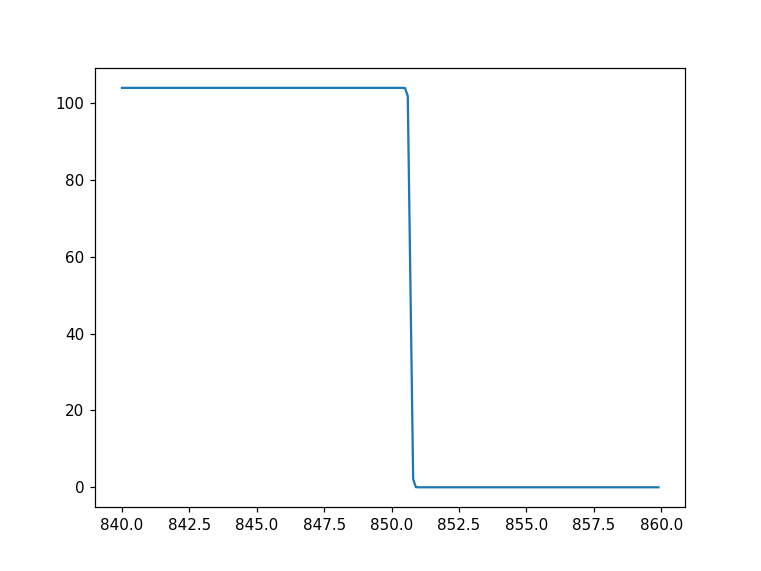

In [9]:
rho_VB  = sim.par.state_vector_0[0, 2]
T       = sim.par.state_vector_0[0, 3] /sim.par.M_VB
enax = np.arange(840, 860, 0.1)
pop =  [sim.fermi(T, rho_VB, E, sim.par.E_f) for E in enax]

plt.figure()
plt.plot(enax, pop)
